In [1]:
import numpy as np
import pandas as pd
from scipy import spatial
# import volpriceinference a vl
import volprice as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.captureWarnings(True)
info_logger = logging.getLogger('basic')
info_handler = logging.FileHandler('../logging.tmp.txt')
info_handler.addFilter(lambda record: record.levelno == logging.INFO)

## Load the data

In [4]:
with pd.HDFStore('../data/spy_daily_estimates_2003-2017_1000_1sec.hdf') as store:
    daily_rtn = store['daily_rtn'] * 252
    vol = store['discrete_vol_est'] * 252**2 
    
    data = pd.concat([daily_rtn, vol.diffusion + vol.jumps], axis=1).dropna()
    data.columns = ['rtn', 'vol']

In [5]:
data.head()

,rtn,vol
2003-01-02,6.419615,8.799756
2003-01-03,0.539956,7.785992
2003-01-06,5.150512,4.586335
2003-01-07,-0.896750,8.294531
2003-01-08,-2.748119,6.446751


In [6]:
data.rtn.var()

5.5232762870876755

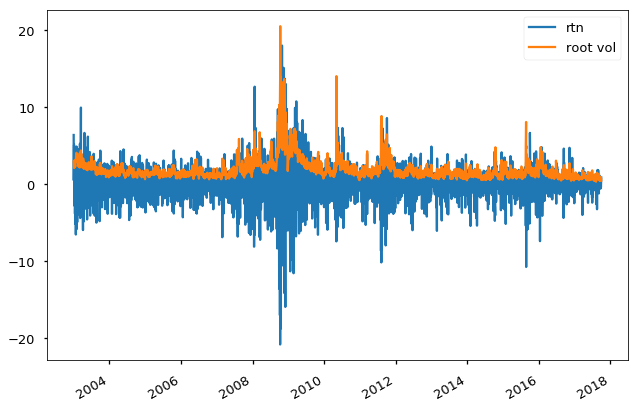

In [8]:
fig1, ax1 = mpl.pyplot.subplots()
data['rtn'].plot(ax=ax1)
data['vol'].apply(np.sqrt).plot(ax=ax1, label='root vol')
ax1.legend()

In [9]:
data.describe()

,rtn,vol
count,3713.000000,3713.000000
mean,0.023421,5.621287
std,2.350165,14.458447
min,-20.781833,0.123335
25%,-0.954041,1.380618
50%,0.128299,2.416002
75%,1.099523,5.030940
max,18.031014,421.880784


In [10]:
omega, omega_cov = vl.estimate_params(data)

In [11]:
vl.estimate_params_strong_id(data)

({'gamma': 0.25965685942691796,
  'beta': 0.1113552770767416,
  'psi': -0.15373902507632284,
  'zeta': 0.9086856628806307,
  'delta': 0.29192719373753634,
  'rho': 0.8262117670231669,
  'scale': 2.5021627472402357,
  'equity_price': 0.4716641977130737,
  'vol_price': -0.12564794130925142},
                   beta     delta  equity_price     gamma       psi       rho  \
 beta          0.000097  0.000000           NaN -0.000035 -0.000091  0.000000   
 delta         0.000000  2.964441           NaN  0.000000  0.000000 -0.337172   
 equity_price       NaN       NaN      0.022942       NaN       NaN       NaN   
 gamma        -0.000035  0.000000           NaN  0.000648 -0.000080  0.000000   
 psi          -0.000091  0.000000           NaN -0.000080  0.000149  0.000000   
 rho           0.000000 -0.337172           NaN  0.000000  0.000000  0.042642   
 scale         0.000000 -2.712415           NaN  0.000000  0.000000  0.275340   
 vol_price          NaN       NaN      0.011834       NaN    

In [30]:
qlr_stats = vl.compute_qlr_stats(omega=omega, omega_cov=omega_cov, vol_dim=50, equity_dim=40, equity_max=3,
                                vol_min=-3)

In [46]:
qlr_stats.to_json('../results/qlr_stats_on_data.tmp.json')

In [28]:
qlr_draws = vl.compute_qlr_sim(omega=omega, omega_cov=omega_cov, vol_dim=50, equity_dim=40, equity_max=3,
                                vol_min=-3, innov_dim=2000, alpha=2.5)

In [47]:
qlr_stats.to_json('../results/qlr_draws_on_data.tmp.json')

In [31]:
accepted_vals = (qlr_stats < qlr_draws).stack().reset_index().rename(columns={0:'value'}).query(
    'value').drop('value', axis='columns')

In [49]:
def constraint(scale, psi, zeta, equity_price):
    
    vol_price  = -1 / scale - ((psi * (equity_price-1) + zeta/2 * (equity_price-1)**2))
    
    return  vol_price

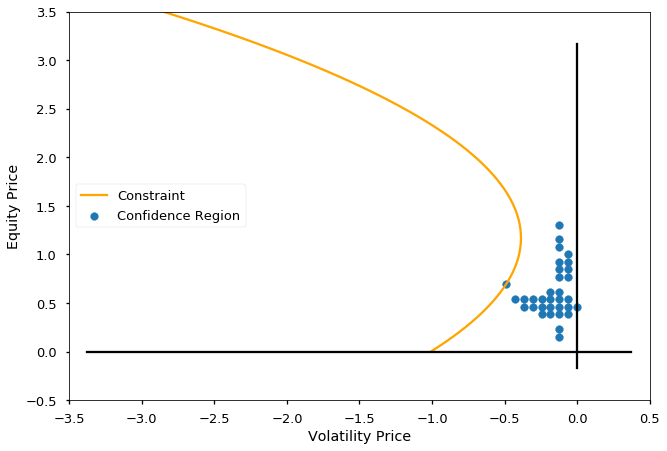

In [60]:
fig3, ax3 = mpl.pyplot.subplots()
ax3.scatter(y=accepted_vals.equity, x=accepted_vals.vol, marker='o', s=60, label='Confidence Region')
ax3.set_xlim([-3.5, .5])
ax3.set_ylim([-.5, 3.5])
yvals = np.linspace(0,5,100)
xvals = [constraint(omega['scale'], omega['psi'], omega['zeta'], x) for x in yvals]
ax3.plot(xvals, yvals, color='orange', label='Constraint')
ax3.axvline(0,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axvline(-15,  ymin=.5 /6, ymax=1 - .5/6, color='black')
ax3.axhline(0,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.axhline(5,  xmin=.5 /16, xmax=1 - .5/16, color='black')
ax3.legend()
ax3.set_ylabel('Equity Price')
ax3.set_xlabel('Volatility Price')
fig3.savefig('../doc/figures/confidence_region.tmp.pdf', frameon=False, pad_inches=0, bbox_inches='tight',
            transparent=True)

In [35]:
accepted_vals.min()

vol      -0.489796
equity    0.153846
dtype: float64

In [36]:
accepted_vals.max()

vol       0.000000
equity    1.307692
dtype: float64